In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from src.record import Record
import matplotlib.ticker as ticker

sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid", palette='deep')

def smooth(df, vals):
    for val in vals:
        smoothed = df[val].rolling(20000, min_periods = 1).mean()
        df.loc[smoothed.index, val] = smoothed

Large Scale

In [53]:
models = {
    'bestfit': 'Best Fit',
    'firstfit': 'First Fit',
    'ppo-ut': 'PPO',
    'caviglione': 'DRL-VMP'
}

df = pd.DataFrame()
for i in np.arange(0, 5, 1, dtype=int):
    for agent in models.keys():
        f = open(f'data/exp_performance/load1.00/{agent}-{i}.json')
        jsonstr = json.load(f)
        record = Record.import_record(agent, jsonstr)
        sample = pd.DataFrame({'Reward': record.rewards, 'CPU Utilisation Mean': np.mean(record.cpu, axis=1), 'CPU Utilisation Variance': np.var(record.cpu, axis=1), 'Memory Utilisation Mean': np.mean(record.cpu, axis=1), 'Memory Utilisation Variance': np.var(record.cpu, axis=1), 'Waiting Ratio': record.waiting_ratio, 'Served VMs': record.served_requests})
        smooth(sample, ['CPU Utilisation Mean', 'CPU Utilisation Variance'])
        sample['Agent'] = models[agent]
        sample['Step'] = sample.index + 1
        df = pd.concat([df, sample])

df = df.reset_index(drop=True)

High load CPU Utilisation mean line graph:

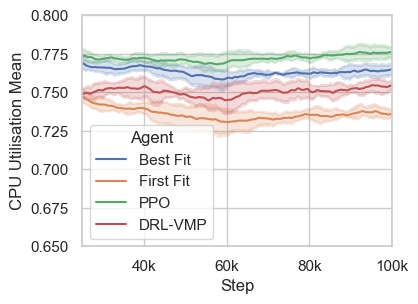

In [54]:
plt.subplots(figsize=(4,3))
g = sns.lineplot(x="Step", y="CPU Utilisation Mean", hue='Agent', data=df)
g.set(xlim=(25000, 100000))
g.set(ylim=(0.65, 0.8))
# Custom x-axis tick formatter
def step_formatter(x, pos):
    return f'{int(x/1000)}k'

g.xaxis.set_major_formatter(ticker.FuncFormatter(step_formatter))

plt.savefig('plots/cpu_mean_line.png', bbox_inches='tight', pad_inches=0)

High load CPU Utilisation std line graph:

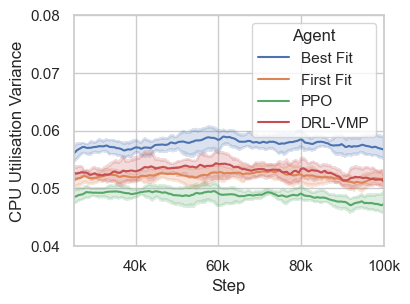

In [49]:
plt.subplots(figsize=(4,3))
g = sns.lineplot(x="Step", y="CPU Utilisation Variance", hue='Agent', data=df)
g.set(xlim=(25000, 100000))
g.set(ylim=(0.04, 0.08))

# Custom x-axis tick formatter
def step_formatter(x, pos):
    return f'{int(x/1000)}k'

g.xaxis.set_major_formatter(ticker.FuncFormatter(step_formatter))

plt.savefig('plots/cpu_var_line.png', bbox_inches='tight', pad_inches=0)

High load served VMs:

In [38]:
models = {
    'bestfit': 'Best Fit',
    'firstfit': 'First Fit',
    'ppo-ut': 'PPO',
    'caviglione': 'DRL-VMP'
}

df = pd.DataFrame()

for agent in models.keys():
    f = open(f'data/exp_performance/load1.00/{agent}-{0}.json')
    jsonstr = json.load(f)
    record = Record.import_record(agent, jsonstr)
    sample = pd.DataFrame({'Waiting Ratio': record.waiting_ratio, 'Served VMs': record.served_requests})
    sample['Agent'] = models[agent]
    sample['Step'] = sample.index + 1
    df = pd.concat([df, sample])

df = df.reset_index(drop=True)

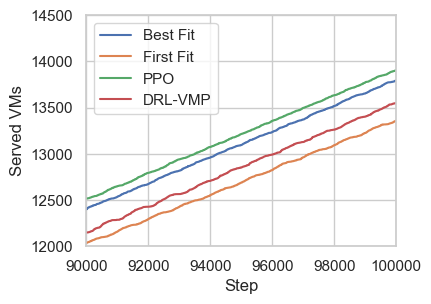

In [46]:
plt.subplots(figsize=(4,3))
g = sns.lineplot(x="Step", y="Served VMs", hue='Agent', data=df)
g.set(xlim=(90000, 100000))
g.set(ylim=(12000,14500))
# put the legend on the top left 
g.legend(loc='upper left')
plt.savefig('plots/vms_line.pdf', bbox_inches='tight', pad_inches=0)

In [40]:
smooth(df, ['Waiting Ratio'])

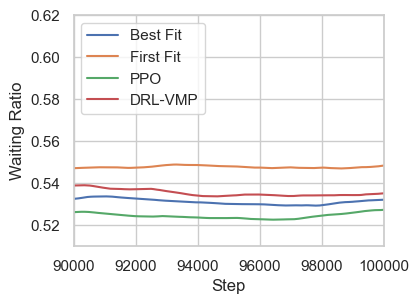

In [45]:
plt.subplots(figsize=(4,3))
g = sns.lineplot(x="Step", y="Waiting Ratio", hue='Agent', data=df)
g.set(xlim=(90000, 100000))
g.set(ylim=(0.51,0.62))
g.legend(loc='upper left')
plt.savefig('plots/waiting_ratios_line.pdf', bbox_inches='tight', pad_inches=0)

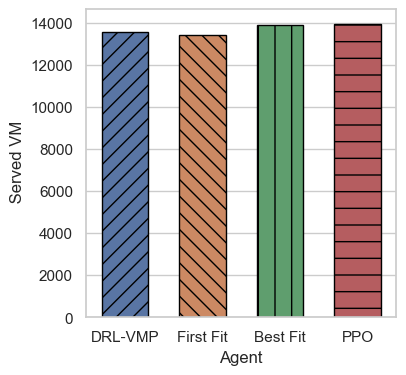

In [46]:
models = {
    'bestfit': 'Best Fit',
    'firstfit': 'First Fit',
    'caviglione': 'DRL-VMP',
    'ppo-ut': 'PPO',
}

plt.subplots(figsize=(4,4))
df = pd.read_csv('data/exp_performance/summary.csv')
for key in models.keys():
    df.replace(key, models[key], inplace=True)
df = df[(df['Agent'].isin(models.values())) & (df[' Load'] == 1.0)]

g = sns.barplot(x="Agent", y=" Served VM", width=0.6 , linewidth=1, edgecolor="0", order=['DRL-VMP', 'First Fit', 'Best Fit', 'PPO'], data=df)
hatches = ["//", "\\\\", "|", "-", "x"]
for i, thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])

plt.savefig('plots/served_bar.pdf', bbox_inches='tight', pad_inches=0)

High load drop rate:

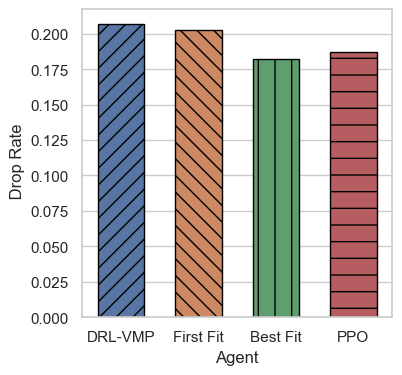

In [6]:
plt.subplots(figsize=(4,4))
g = sns.barplot(x="Agent", y=" Drop Rate", width=0.6,linewidth=1, edgecolor="0", order=['DRL-VMP', 'First Fit', 'Best Fit', 'PPO'], data=df)
hatches = ["//", "\\\\", "|", "-", "x"]
for i, thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])
plt.savefig('plots/drop_bar.pdf', bbox_inches='tight', pad_inches=0)

High load waiting ratio: 

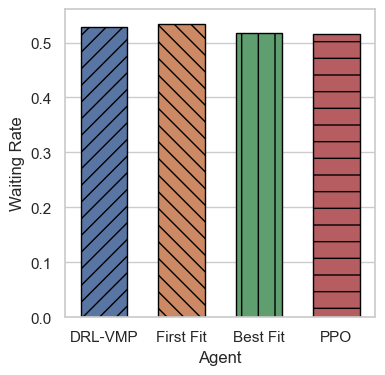

In [45]:
plt.subplots(figsize=(4,4))
g = sns.barplot(x="Agent", y=" Waiting Ratio", width=0.6,linewidth=1, edgecolor="0", order=['DRL-VMP', 'First Fit', 'Best Fit', 'PPO'], data=df)
g.set(ylabel='Waiting Rate')
hatches = ["//", "\\\\", "|", "-", "x"]
for i, thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])
plt.savefig('plots/waiting_bar.pdf', bbox_inches='tight', pad_inches=0)

Load vs total served: 

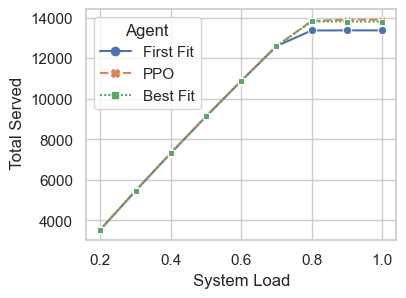

In [22]:
df = pd.read_csv('data/exp_suspension/data.csv')
df['System Load'] = df[' Load']
models = {
    'bestfit': 'Best Fit',
    'firstfit': 'First Fit',
    'ppo-ut': 'PPO'
}
for key in models.keys():
    df.replace(key, models[key], inplace=True)
loads = df[(df[' Service Length'] == 1000) & (df['Agent'].isin(models.values()))].drop_duplicates()
loads['Suspend Action Ratio'] = loads[' Valid Suspend Actions'] / loads[' Life']
loads['Suspensions per VM'] = loads[' Valid Suspend Actions'] / loads[' Total Served']

plt.subplots(figsize=(4,3))
sns.lineplot(x="System Load", y=" Total Served", markers=True, dashes=True, style='Agent', hue='Agent', data=loads)
plt.savefig('plots/load_served_line.pdf', bbox_inches='tight', pad_inches=0)

Load vs Suspensions per vm:

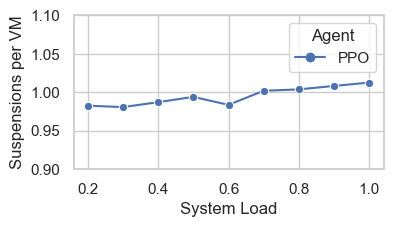

In [29]:
plt.subplots(figsize=(4,2)) 
g = sns.lineplot(x="System Load", y="Suspensions per VM", markers=True, dashes=True, style='Agent', hue='Agent', data=loads[loads['Agent'] == 'PPO'])
g.set(ylim=(0.9, 1.1))
plt.savefig('plots/load_suspend_per_vm_line.pdf', bbox_inches='tight', pad_inches=0)

Load vs pending:

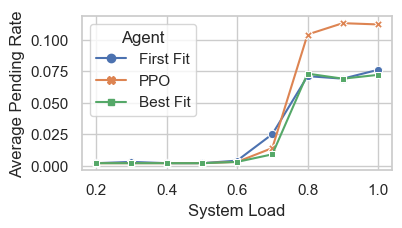

In [30]:
plt.subplots(figsize=(4,2)) 
loads = df[(df[' Service Length'] == 1000) & (df['Agent'].isin(models.values()))].drop_duplicates()
g = sns.lineplot(x="System Load", y=" Average Pending", markers=True, dashes=False, style='Agent', hue='Agent', data=loads)
g.set(ylabel='Average Pending Rate')
plt.savefig('plots/load_pending_line.pdf', bbox_inches='tight', pad_inches=0)

Load vs slowdown:

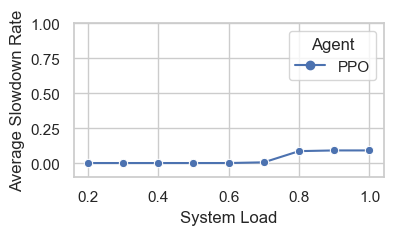

In [55]:
plt.subplots(figsize=(4,2)) 
g = sns.lineplot(x="System Load", y=" Average Slowdown", markers=True, dashes=True, style='Agent', hue='Agent', data=loads[loads['Agent'] == 'PPO'])
g.set(ylabel='Average Slowdown Rate')
g.set(ylim=(-0.1, 1))
plt.savefig('plots/load_slowdown_line.pdf', bbox_inches='tight', pad_inches=0)

Service Length vs total served:

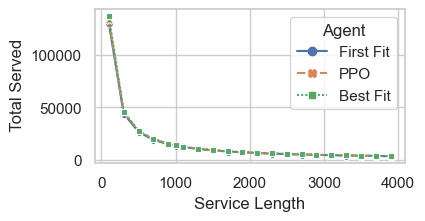

In [33]:
servrates = df[(df[' Load'] == 1) & (df['Agent'].isin(models.values()))].drop_duplicates()
servrates['Suspend Action Ratio'] = servrates[' Valid Suspend Actions'] / servrates[' Life']
servrates['Suspensions per VM'] = servrates[' Valid Suspend Actions'] / servrates[' Total Served']
servrates['Service Length'] = servrates[' Service Length']
plt.subplots(figsize=(4,2)) 
sns.lineplot(x="Service Length", y=" Total Served", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates)
plt.savefig('plots/service_length_served_line.pdf', bbox_inches='tight', pad_inches=0)

Service length vs suspend action ratio: 

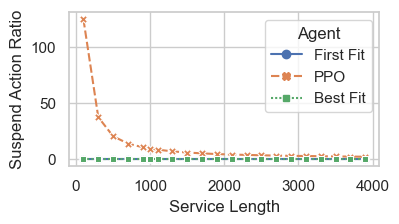

In [34]:
plt.subplots(figsize=(4,2)) 
sns.lineplot(x="Service Length", y="Suspend Action Ratio", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates)
plt.savefig('plots/service_length_suspend_ratio_line.pdf', bbox_inches='tight', pad_inches=0)

Service length vs suspend action ratio: 

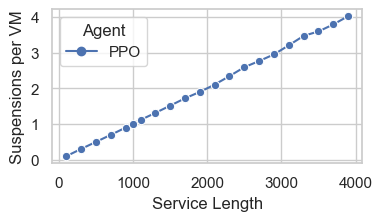

In [36]:
plt.subplots(figsize=(4,2)) 
g = sns.lineplot(x="Service Length", y="Suspensions per VM", markers=True, dashes=True, hue='Agent', style='Agent', data=servrates[servrates['Agent'] == 'PPO'])
plt.savefig('plots/service_length_suspend_per_vm_line.pdf', bbox_inches='tight', pad_inches=0)

Service length vs pending:

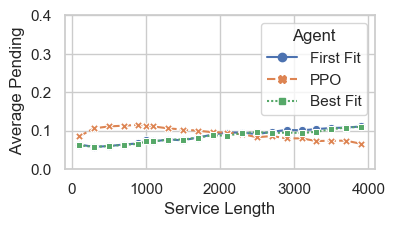

In [38]:
plt.subplots(figsize=(4,2)) 
g = sns.lineplot(x="Service Length", y=" Average Pending", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates)
g.set(ylim=(0, 0.4))
plt.savefig('plots/service_length_pending_line.pdf', bbox_inches='tight', pad_inches=0)

Service length vs slowdown:

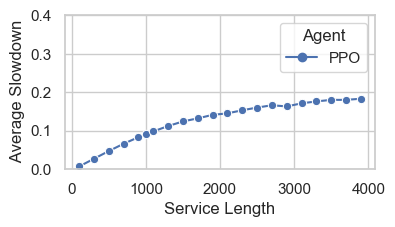

In [42]:
plt.subplots(figsize=(4,2)) 
g = sns.lineplot(x="Service Length", y=" Average Slowdown", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates[servrates['Agent'] == 'PPO'])
g.set(ylim=(0, 0.4))
plt.savefig('plots/service_length_slowdown_line.pdf', bbox_inches='tight', pad_inches=0)

/var/folders/wj/_8blp7yj4d5c6ghh_knwzdf40000gn/T/ipykernel_51512/4061741923.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])


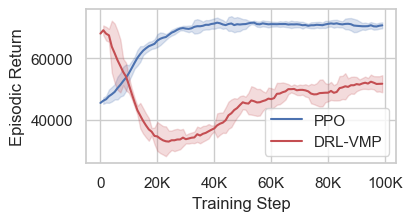

In [18]:
try:
    df1 = pd.read_csv('data/exp_training/ppo-ut.csv')
    df1['Rolling Mean'] = df1['Value'].rolling(window=10, min_periods=1).mean()
    df1['Rolling Std'] = df1['Value'].rolling(window=5, min_periods=1).std()

except FileNotFoundError:
    print("Extract the ep_return from tensorboard log and save it as data/exp_training/ppo-ut.csv")
    df1 = None

try:
    df2 = pd.read_csv('data/exp_training/caviglione-ut.csv')
    df2['Rolling Mean'] = df2['Value'].rolling(window=10, min_periods=1).mean()
    df2['Rolling Std'] = df2['Value'].rolling(window=5, min_periods=1).std()

except FileNotFoundError:
    print("Extract the ep_return from tensorboard log and save it as data/exp_training/caviglione-ut.csv")
    df2 = None

if df1 is not None and df2 is not None:
    plt.subplots(figsize=(4, 2))

    # Plot the smoothed line for the first dataframe
    g = sns.lineplot(x=df1['Step'], y=df1['Rolling Mean'], label='PPO', linestyle='-', color='b')
    plt.fill_between(df1['Step'], df1['Rolling Mean'] - df1['Rolling Std'], df1['Rolling Mean'] + df1['Rolling Std'], color='b', alpha=0.2)
    
    # Plot the smoothed line for the second dataframe
    g = sns.lineplot(x=df2['Step'], y=df2['Rolling Mean'], label='DRL-VMP', linestyle='-', color='r')
    plt.fill_between(df2['Step'], df2['Rolling Mean'] - df2['Rolling Std'], df2['Rolling Mean'] + df2['Rolling Std'], color='r', alpha=0.2)
    
    # Set the x-axis labels and title
    g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])
    g.set(ylabel='Episodic Return')
    g.set(xlabel='Training Step')
    
    plt.legend()
    plt.savefig('plots/return.pdf', bbox_inches='tight', pad_inches=0)

/var/folders/wj/_8blp7yj4d5c6ghh_knwzdf40000gn/T/ipykernel_51512/4158710700.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])


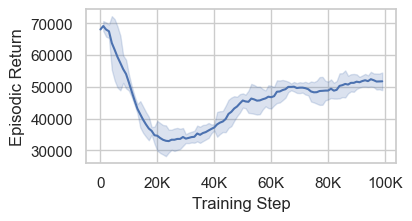

In [19]:
try:
    df = pd.read_csv('data/exp_training/caviglione-ut.csv')
    
    # Calculate rolling mean and standard deviation
    df['Rolling Mean'] = df['Value'].rolling(window=10, min_periods=1).mean()
    df['Rolling Std'] = df['Value'].rolling(window=5, min_periods=1).std()
    
    plt.subplots(figsize=(4,2))
    
    # Plot the smoothed line
    g = sns.lineplot(x=df['Step'], y=df['Rolling Mean'])
    g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])
    
    # Fill the area between the upper and lower bounds of the variation
    plt.fill_between(df['Step'], df['Rolling Mean'] - df['Rolling Std'], df['Rolling Mean'] + df['Rolling Std'], color='b', alpha=0.2)
    
    g.set(ylabel='Episodic Return')
    g.set(xlabel='Training Step')
    
    plt.savefig('plots/caviglione-return.pdf', bbox_inches='tight', pad_inches=0)
except FileNotFoundError:
    print("Extract the ep_return from tensorboard log and save it as data/exp_training/caviglione-ut.csv")

/var/folders/wj/_8blp7yj4d5c6ghh_knwzdf40000gn/T/ipykernel_51512/3917386686.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Beta', y='CPU Utilisation Mean', data=df, ci=None)


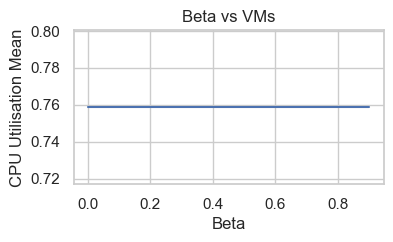

<Figure size 640x480 with 0 Axes>

In [47]:
df = pd.DataFrame()
for i in np.arange(0, 1, 0.1):
    f = open(f'data/exp_beta/{i:.1f}.json')
    jsonstr = json.load(f)
    record = Record.import_record("ppo", jsonstr)
    sample = pd.DataFrame({'Beta': record.env_config["beta"], 'CPU Utilisation Mean': np.mean(record.cpu, axis=1), 'CPU Utilisation Variance': np.var(record.cpu, axis=1), 'VMs Served': record.served_requests})
    smooth(sample, ['CPU Utilisation Mean', 'CPU Utilisation Variance', 'VMs Served'])
    sample['Step'] = sample.index + 1
    df = pd.concat([df, sample])

df = df.reset_index(drop=True)

plt.figure(figsize=(4, 2))
sns.lineplot(x='Beta', y='CPU Utilisation Mean', data=df, ci=None)
plt.title('Beta vs VMs')
plt.show()

plt.savefig('plots/beta.pdf', bbox_inches='tight', pad_inches=0)


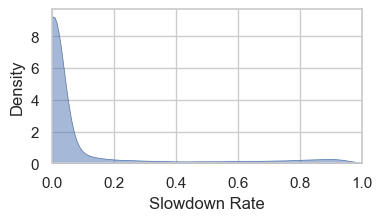

In [58]:
f = open(f'data/exp_performance/load1.00/ppo-ut-0.json')
jsonstr = json.load(f)
record = Record.import_record('PPO', jsonstr)
slowdowns = np.array(record.slowdown_rates)
plt.figure(figsize=(4, 2))
g = sns.kdeplot(data=slowdowns, fill=True, common_norm=False, alpha=0.5, linewidth=0.5)
g.set(ylabel='Density')
g.set(xlabel='Slowdown Rate')
g.set(xlim=(0, 1))
plt.savefig('plots/slowdown_kde.pdf', bbox_inches='tight', pad_inches=0)

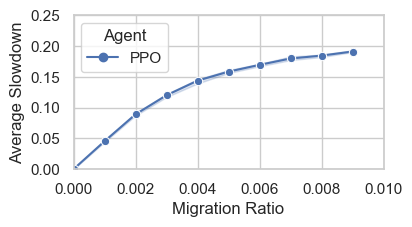

In [2]:
df = pd.read_csv('data/exp_migration_ratio/data.csv')
models = {
    'ppo': 'PPO',
    'bestfit': 'Best Fit',
    'firstfit': 'First Fit'
}
for key in models.keys():
    df.replace(key, models[key], inplace=True)
# choose PPO and Best Fit only
df = df[(df['Agent'].isin(models.values()))]
plt.figure(figsize=(4, 2))
g = sns.lineplot(x='Migration Ratio', y='Average Slowdown', data=df[df['Agent'] == 'PPO'], markers=True, dashes=True, style='Agent', hue='Agent')
g.set(xlim=(0, 0.01))
g.set(ylim=(0, 0.25))
plt.savefig('plots/migration_raio_slowdown.pdf', bbox_inches='tight', pad_inches=0)

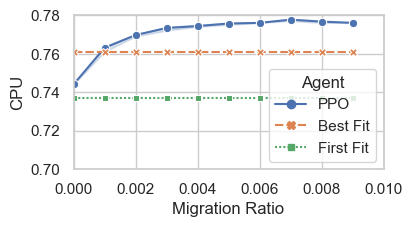

In [4]:
plt.figure(figsize=(4, 2))
g = sns.lineplot(x='Migration Ratio', y='CPU', data=df, markers=True, dashes=True, style='Agent', hue='Agent')
g.set(xlim=(0, 0.01))
g.set(ylim=(0.7, 0.8))
plt.savefig('plots/migration_raio_cpu.pdf', bbox_inches='tight', pad_inches=0)